In [185]:
# test sampling a polar grid
import yt
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse






In [186]:
binary_mass = +2.71811e+00
max_excise_factor = 2.0

# Define arguments with default values instead of using argparse
# This will work better in a notebook environment
class Args:
    def __init__(self):
        self.simname = "250528_BBH_r70_moreplots_restart"
        self.skipevery = 1
        self.maxframes = 40000
        self.outR = 320.0
        self.innerR = -1.0
        self.bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
        self.bbh2_x = (70.49764373525885/2+2.926860031395978)/binary_mass
        self.bbh1_r = 3.98070/binary_mass
        self.bbh2_r = 3.98070/binary_mass
        self.binary_omega = -0.002657634562418009 * 2.71811
        self.excise_factor = 1.5
        self.integratefield = 'VOLUME_X'
        self.allfields = False
        self.surface = False
        self.outplot = False
        self.plotsum = False
        self.fix_metric_error = True
        self.psipow = 2.0

# Create args object instead of parsing command line
args = Args()

# Uncomment and modify these lines to change parameters as needed
# args.simname = "your_simulation_name"
# args.outR = 700.0
# args.allfields = True

# Extract values from args for convenience
simname = args.simname
skipevery = args.skipevery
maxframes = args.maxframes
outR = args.outR
innerR = args.innerR
bbh1_x = args.bbh1_x
bbh2_x = args.bbh2_x
bbh1_r = args.bbh1_r
bbh2_r = args.bbh2_r
binary_omega = args.binary_omega
excise_factor = args.excise_factor
integratefield = args.integratefield
allfields = args.allfields
surface = args.surface
outplot = args.outplot
plotsum = args.plotsum
fix_metric_error = args.fix_metric_error
psipow = args.psipow

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"
rundir = basedir + simname +"/"

# make /pscratch/sd/x/xinshuo/plotGReX/tmp if it doesn't exist
if not os.path.exists(plotdir + "tmp"):
    os.makedirs(plotdir + "tmp")


plt_dirs = sorted([d for d in os.listdir(rundir) if d.startswith('plt') and d[3:].isdigit()], key=lambda x: int(x[3:]))
plt_dirs = plt_dirs[::skipevery]

if len(plt_dirs) > maxframes:
    plt_dirs = plt_dirs[:maxframes]

results = []
# define the mesh and compute them only one for all levels, to save time and memory
all_level_xmeshs = {}
all_level_ymeshs = {}

In [187]:
len(plt_dirs)

1576

In [188]:
# for frameidx, plt_dir in enumerate(plt_dirs):

frameidx = 1000
plt_dir = plt_dirs[frameidx]
print(plt_dir)



ds = yt.load(os.path.join(rundir, plt_dir))

level_left_edges = np.array([ds.index.grid_left_edge[np.where(ds.index.grid_levels==[i])[0]].min(axis=0)  for i in range(ds.max_level+1)])
level_right_edges = np.array([ds.index.grid_right_edge[np.where(ds.index.grid_levels==[i])[0]].max(axis=0)  for i in range(ds.max_level+1)])
level_dxs = ds.index.level_dds
level_dims = (level_right_edges - level_left_edges + 1e-10) / level_dxs
level_dims = level_dims.astype(int)
sph = ds.sphere(ds.domain_center, (outR, "code_length"))

field_ds_levels = {}
vol_x, vol_y, vol_z = 0.0, 0.0, 0.0
mom_x, mom_y, mom_z = 0.0, 0.0, 0.0
torque = 0.0 # torque = x*Fy - y*Fx
L_z = 0.0 # angular momentum


yt : [INFO     ] 2025-06-12 02:17:28,681 Parameters: current_time              = 7005.00347900391
yt : [INFO     ] 2025-06-12 02:17:28,681 Parameters: domain_dimensions         = [640 640   1]
yt : [INFO     ] 2025-06-12 02:17:28,682 Parameters: domain_left_edge          = [-1610. -1610.     0.]
yt : [INFO     ] 2025-06-12 02:17:28,683 Parameters: domain_right_edge         = [1.61e+03 1.61e+03 1.00e+00]


plt712857


Created polar mesh with 1000 logarithmic radial bins from r=0.5 to r=320.0
Angular resolution: 1000 bins (0.36 degrees per bin)
dr range: 0.0032444491905392336 to 2.0630604920582414
dtheta: 0.006289474781961547 radians (0.36036036036036034 degrees)


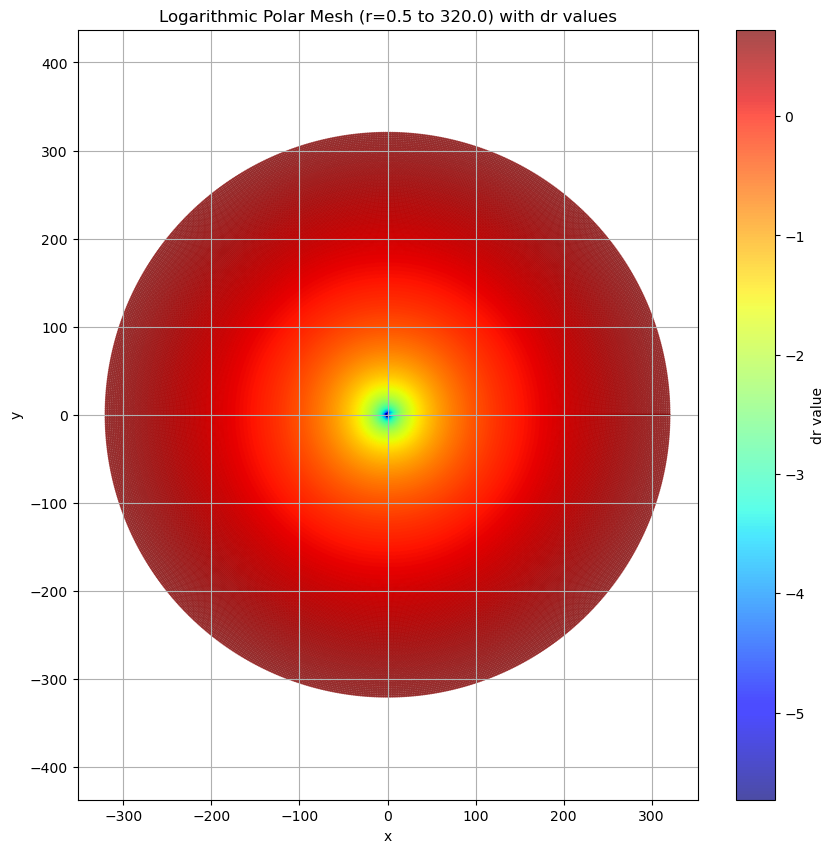

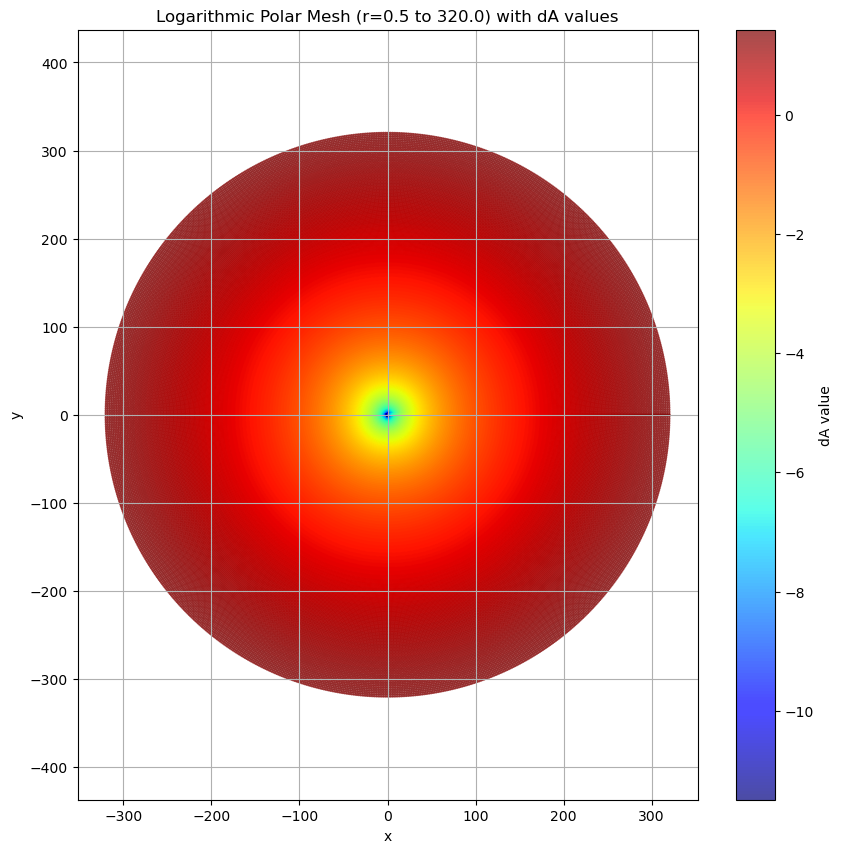

In [189]:
# create a polar mesh

# Create a polar mesh from r=20 to outR with logarithmic radial spacing
r_min = 0.5
r_max = outR
num_r = 1000  # Number of radial bins
num_theta = 1000  # Number of angular bins (5-degree intervals)

# Create the radial bins with logarithmic spacing and angular bins
r_bins = np.logspace(np.log10(r_min), np.log10(r_max), num_r)
# r_bins = np.linspace(r_min, r_max, num_r)
theta_bins = np.linspace(0, 2*np.pi, num_theta)

# Create meshgrid for polar coordinates
r_mesh, theta_mesh = np.meshgrid(r_bins, theta_bins)

# Calculate dr and dtheta mesh (vectorized)
dr_vals = np.diff(r_bins, append=r_bins[-1] + (r_bins[-1] - r_bins[-2]))
dtheta = theta_bins[1] - theta_bins[0]  # Constant for uniform angular spacing

# Expand to match mesh dimensions
dr_mesh = np.tile(dr_vals, (num_theta, 1))
dtheta_mesh = np.full_like(theta_mesh, dtheta)
# Area elements for integration (r*dr*dtheta)
dA_mesh = r_mesh * dr_mesh * dtheta_mesh

# Convert to Cartesian coordinates for sampling
x_mesh = r_mesh * np.cos(theta_mesh)
y_mesh = r_mesh * np.sin(theta_mesh)


# Print mesh information
print(f"Created polar mesh with {num_r} logarithmic radial bins from r={r_min} to r={r_max}")
print(f"Angular resolution: {num_theta} bins ({360/num_theta} degrees per bin)")
print(f"dr range: {dr_mesh.min()} to {dr_mesh.max()}")
print(f"dtheta: {dtheta} radians ({dtheta*180/np.pi} degrees)")

# Plot the mesh with dr_mesh values as colors
plt.figure(figsize=(10, 10))
scatter = plt.scatter(x_mesh, y_mesh, s=0.5, c=np.log(dr_mesh), cmap='jet', alpha=0.7)
plt.colorbar(scatter, label='dr value')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title(f'Logarithmic Polar Mesh (r={r_min} to {r_max}) with dr values')
plt.grid(True)
# plt.xlim(-20,20)
# plt.ylim(-20,20)
# plt.savefig(f"{plotdir}/tmp/polar_mesh_r{r_min}_to_r{r_max}.png")
plt.show()
# Plot the mesh with dr_mesh values as colors
plt.figure(figsize=(10, 10))
scatter = plt.scatter(x_mesh, y_mesh, s=0.5, c=np.log(dA_mesh), cmap='jet', alpha=0.7)
plt.colorbar(scatter, label='dA value')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title(f'Logarithmic Polar Mesh (r={r_min} to {r_max}) with dA values')
plt.grid(True)
# plt.xlim(-20,20)
# plt.ylim(-20,20)
# plt.savefig(f"{plotdir}/tmp/polar_mesh_r{r_min}_to_r{r_max}.png")
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


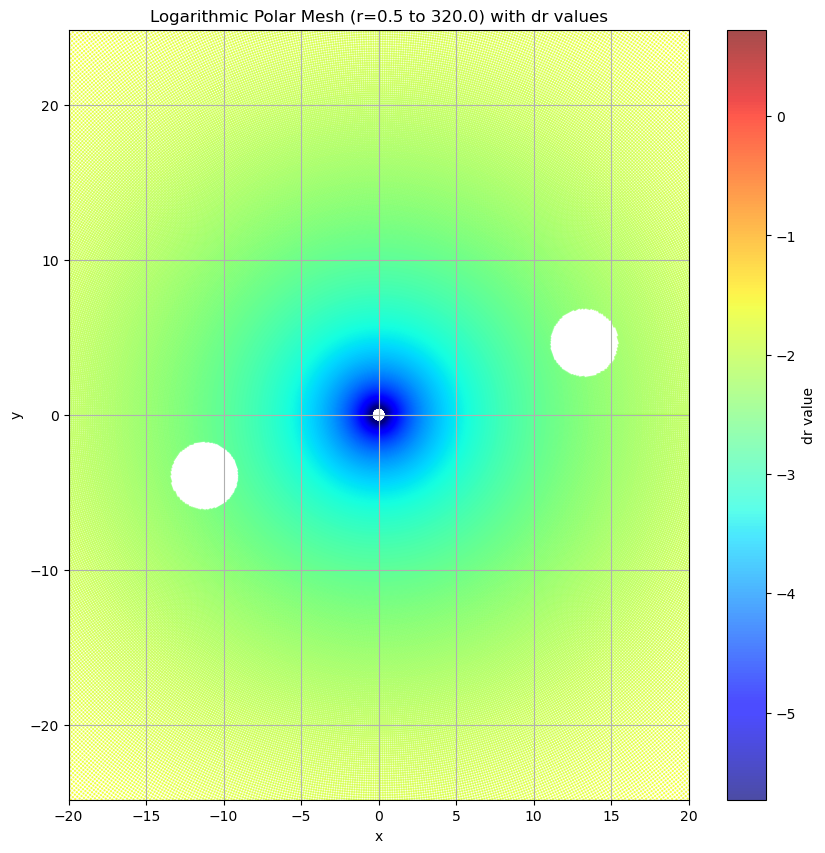

In [190]:

# Initialize field arrays for the polar mesh
vol_x_mesh = np.zeros_like(r_mesh)
vol_y_mesh = np.zeros_like(r_mesh)
vol_z_mesh = np.zeros_like(r_mesh)
mom_x_mesh = np.zeros_like(r_mesh)
mom_y_mesh = np.zeros_like(r_mesh)
mom_z_mesh = np.zeros_like(r_mesh)
psi_mesh = np.zeros_like(r_mesh)

# Track which points have been assigned
assigned = np.zeros_like(r_mesh, dtype=bool)

# Black hole positions at current time
t = float(ds.current_time)
bh1_center = np.array([bbh1_x*np.cos(-t*binary_omega), bbh1_x*np.sin(-t*binary_omega)])
bh2_center = np.array([bbh2_x*np.cos(-t*binary_omega), bbh2_x*np.sin(-t*binary_omega)])

# Create masks for black hole excision
bh1_dist = np.sqrt((x_mesh - bh1_center[0])**2 + (y_mesh - bh1_center[1])**2)
bh2_dist = np.sqrt((x_mesh - bh2_center[0])**2 + (y_mesh - bh2_center[1])**2)
bh1_mask = bh1_dist < bbh1_r * excise_factor
bh2_mask = bh2_dist < bbh2_r * excise_factor
excision_mask = bh1_mask | bh2_mask


# test excision mask
plt.figure(figsize=(10, 10))
scatter = plt.scatter(x_mesh[~excision_mask], y_mesh[~excision_mask], s=0.5, c=np.log(dr_mesh[~excision_mask]), cmap='jet', alpha=0.7)
plt.colorbar(scatter, label='dr value')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title(f'Logarithmic Polar Mesh (r={r_min} to {r_max}) with dr values')
plt.grid(True)
plt.xlim(-20,20)
plt.ylim(-20,20)
# plt.savefig(f"{plotdir}/tmp/polar_mesh_r{r_min}_to_r{r_max}.png")
plt.show()


In [201]:
# loop over levels, get the field value 
for level in range(ds.max_level+1):
    field_ds_levels[level] = ds.covering_grid(level=level, 
                                                 left_edge=level_left_edges[level], 
                                                 dims=level_dims[level])

    # Create a mask for points inside this level's domain
    level_mask = ((x_mesh >= level_left_edges[level][0]) & 
                    (x_mesh <= level_right_edges[level][0]) & 
                    (y_mesh >= level_left_edges[level][1]) & 
                    (y_mesh <= level_right_edges[level][1]))
    
    # For all levels except the finest, exclude points in finer levels
    if level < ds.max_level:
        next_level_mask = ((x_mesh >= level_left_edges[level+1][0]) & 
                            (x_mesh <= level_right_edges[level+1][0]) & 
                            (y_mesh >= level_left_edges[level+1][1]) & 
                            (y_mesh <= level_right_edges[level+1][1]))
        level_mask = level_mask & ~next_level_mask
    
    # Also exclude points inside black holes
    level_mask = level_mask & ~excision_mask
    
    # Skip level if no points are in this mask
    if not np.any(level_mask):
        print(f"  No points to sample in level {level}, skipping")
        continue


        
    # Mark these points as assigned
    assigned = assigned | level_mask
    
    # Compute W and psi for the current level
    W_field = field_ds_levels[level]['W'][:].sum(axis=2)
    psi_values = np.zeros_like(r_mesh)
    
    # Sample all field values for this level
    for i, j in zip(*np.where(level_mask)):
        x, y = x_mesh[i, j], y_mesh[i, j]
        
        # Convert to array indices for direct access (faster than calling sample_field_value repeatedly)
        xmin, xmax = level_left_edges[level][0], level_right_edges[level][0]
        ymin, ymax = level_left_edges[level][1], level_right_edges[level][1]
        nx, ny = W_field.shape
        
        dx = (xmax - xmin) / nx
        dy = (ymax - ymin) / ny
        
        idx_i = int(np.clip(np.floor((x - xmin) / dx), 0, nx-1))
        idx_j = int(np.clip(np.floor((y - ymin) / dy), 0, ny-1))
        
        # Get W value and compute psi
        W_val = W_field[idx_i, idx_j]
        if W_val > 0:
            psi_val = 1.0 / np.sqrt(W_val)
        else:
            psi_val = 1.0
        psi_mesh[i, j] = psi_val
        
        # Compute sqrt(gamma) for volume elements
        sqrt_gamma = np.power(psi_val, 6)
        
        # Sample all fields
        for field in ['VOLUME_X', 'VOLUME_Y', 'VOLUME_Z', 'SMOMENTUM_X', 'SMOMENTUM_Y', 'SMOMENTUM_Z']:
            val = field_ds_levels[level][field][:][idx_i, idx_j, :].sum()
            
            # Apply metric corrections
            if field.startswith('VOLUME'):
                if fix_metric_error:
                    # Divide by sqrt(gamma) to fix the metric error
                    # val = val 
                    val = val / sqrt_gamma
            else:  # SMOMENTUM fields
                # Multiply by sqrt(gamma) for proper volume integration
                val = val * sqrt_gamma
            
            # Store in appropriate mesh
            if field == 'VOLUME_X':
                vol_x_mesh[i, j] = val
            elif field == 'VOLUME_Y':
                vol_y_mesh[i, j] = val
            elif field == 'VOLUME_Z':
                vol_z_mesh[i, j] = val
            elif field == 'SMOMENTUM_X':
                mom_x_mesh[i, j] = val
            elif field == 'SMOMENTUM_Y':
                mom_y_mesh[i, j] = val
            elif field == 'SMOMENTUM_Z':
                mom_z_mesh[i, j] = val



    

  No points to sample in level 0, skipping
  No points to sample in level 1, skipping


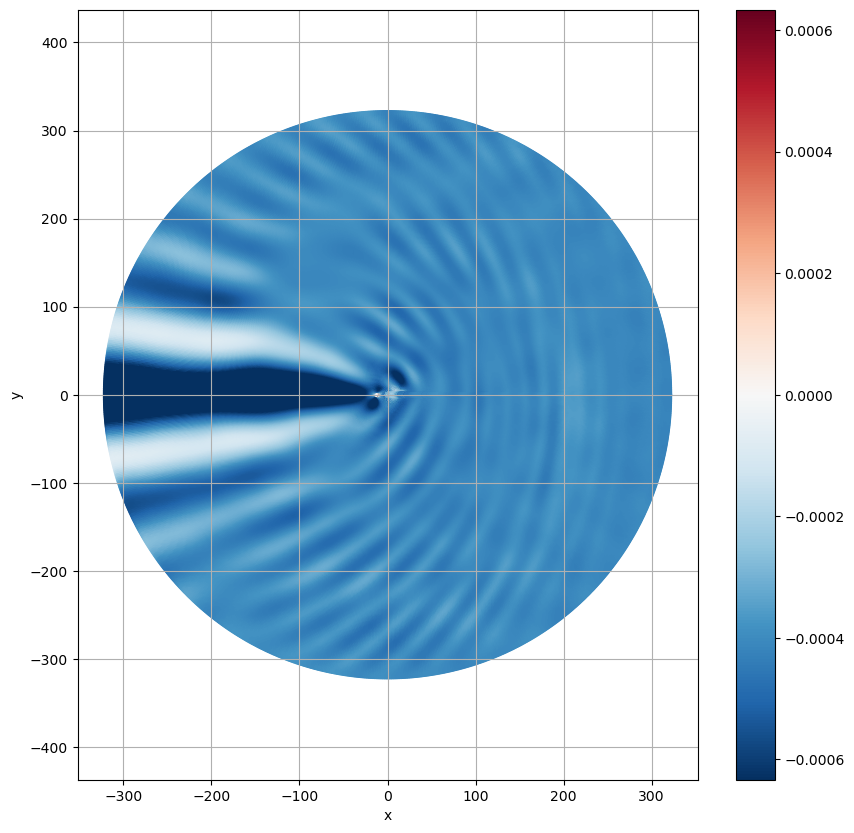

In [202]:
# test excision mask
plt.figure(figsize=(10, 10))
vmax = np.abs(mom_x_mesh).max()*0.5
scatter = plt.scatter(x_mesh, y_mesh, s=10, c=(mom_x_mesh), cmap='RdBu_r', vmin=-vmax, vmax=vmax, alpha=1)
plt.colorbar(scatter)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid(True)
# plt.xlim(-20,20)
# plt.ylim(-20,20)
# plt.savefig(f"{plotdir}/tmp/polar_mesh_r{r_min}_to_r{r_max}.png")
plt.show()

In [203]:
# Check if we have any unassigned points that should be assigned
if np.any(~assigned & ~excision_mask & (r_mesh <= outR)):
    n_unassigned = np.sum(~assigned & ~excision_mask & (r_mesh <= outR))
    print(f"Warning: {n_unassigned} points within r={outR} not assigned to any level")

# Calculate the volume integrals
# For torque, we need x * vol_y - y * vol_x
torque_mesh = (x_mesh * vol_y_mesh - y_mesh * vol_x_mesh) * np.power(psi_mesh, psipow)
# For angular momentum, we need x * mom_y - y * mom_x
L_z_mesh = (x_mesh * mom_y_mesh - y_mesh * mom_x_mesh) * np.power(psi_mesh, psipow)

# Integrate using the area elements
vol_x = np.sum(vol_x_mesh * dA_mesh)
vol_y = np.sum(vol_y_mesh * dA_mesh)
vol_z = np.sum(vol_z_mesh * dA_mesh)
mom_x = np.sum(mom_x_mesh * dA_mesh)
mom_y = np.sum(mom_y_mesh * dA_mesh)
mom_z = np.sum(mom_z_mesh * dA_mesh)
torque = np.sum(torque_mesh * dA_mesh)
L_z = np.sum(L_z_mesh * dA_mesh)

# also save the radial integrated fields
vol_x_radial = np.sum(vol_x_mesh, axis=1)
vol_y_radial = np.sum(vol_y_mesh, axis=1)
vol_z_radial = np.sum(vol_z_mesh, axis=1)
mom_x_radial = np.sum(mom_x_mesh, axis=1)
mom_y_radial = np.sum(mom_y_mesh, axis=1)
mom_z_radial = np.sum(mom_z_mesh, axis=1)
torque_radial = np.sum(torque_mesh, axis=1)
L_z_radial = np.sum(L_z_mesh, axis=1)


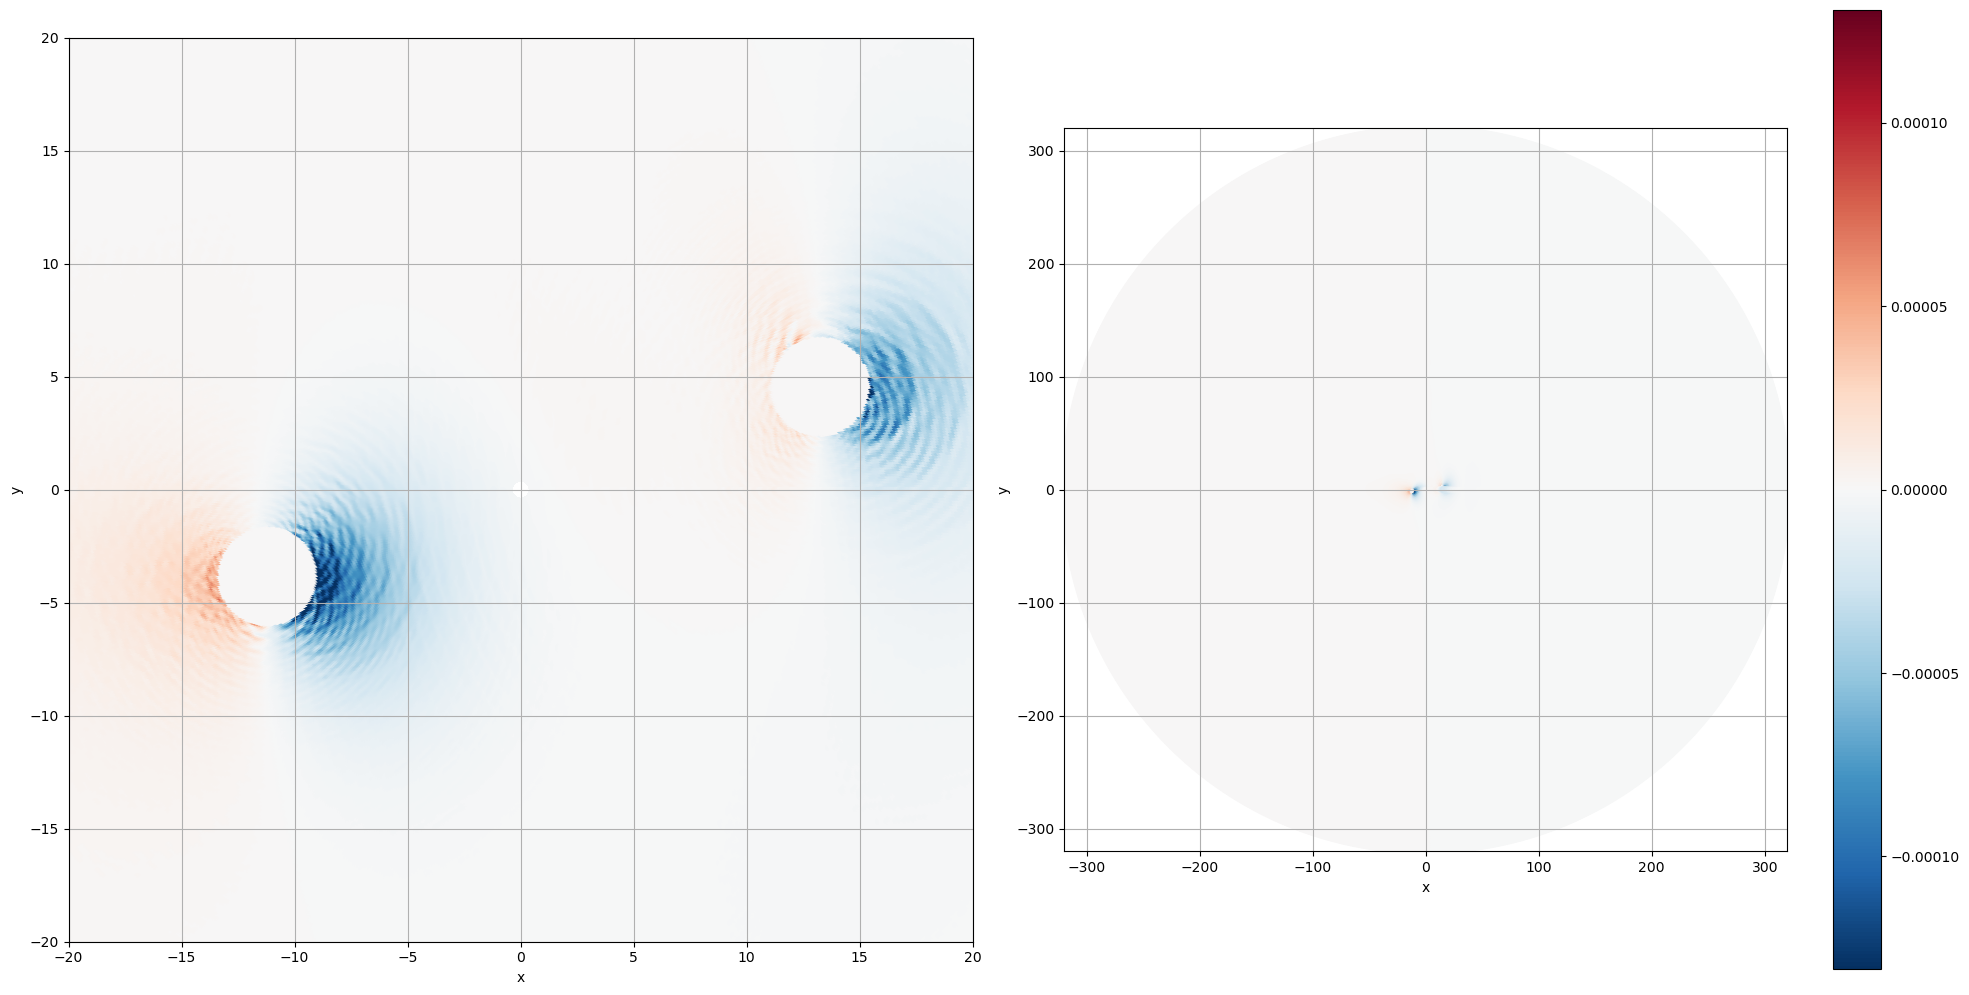

In [204]:
checkfieldmesh = vol_x_mesh

# Create a two-panel plot 
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Left panel: zoomed in view (-20, 20)
vmax = np.abs(checkfieldmesh).max()*0.5
scatter1 = axes[0].scatter(x_mesh, y_mesh, s=10, c=checkfieldmesh, cmap='RdBu_r', vmin=-vmax, vmax=vmax, alpha=1)
# fig.colorbar(scatter1, ax=axes[0], label='Torque')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_xlim(-20, 20)
axes[0].set_ylim(-20, 20)
axes[0].grid(True)
# axes[0].set_title('Zoomed In View')
axes[0].set_aspect('equal')

# Right panel: wider view (-320, 320)
scatter2 = axes[1].scatter(x_mesh, y_mesh, s=10, c=checkfieldmesh, cmap='RdBu_r', vmin=-vmax, vmax=vmax, alpha=1)
fig.colorbar(scatter2, ax=axes[1])
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_xlim(-320, 320)
axes[1].set_ylim(-320, 320)
axes[1].grid(True)
# axes[1].set_title('Wide View')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [205]:
psipow=2.0

In [206]:

    # Store the results
results.append([ds.current_time, vol_x, vol_y, vol_z, mom_x, mom_y, mom_z, torque, L_z])

In [210]:
results[-2]

[unyt_quantity(7005.003479, 'code_time'),
 -0.0032815392546607135,
 0.0005098894681369318,
 0.0,
 -133.40286391979006,
 -0.1970739846622462,
 0.0,
 -0.008995403381736634,
 8.44598765370118]

In [208]:
# previous integration with 200*200 or 400*400 bins

# [[unyt_quantity(7005.003479, 'code_time'),
#   -0.003439968073525434,
#   0.0005916592964350487,
#   0.0,
#   -136.85606888532988,
#   -0.20173365940293553,
#   0.0,
#   -0.007570213751255012,
#   7.395414963262823],
#  [unyt_quantity(7005.003479, 'code_time'),
#   -0.0033533204639065646,
#   0.000535479959999945,
#   0.0,
#   -135.49634936280393,
#   -0.20236815363249847,
#   0.0,
#   -0.008526668339492859,
#   7.390507393307345]]

In [212]:
# check against previous cartesian integration
fname = f"/pscratch/sd/x/xinshuo/plotGReX/{simname}_2d_integrals_outR{outR:.1f}_excise{excise_factor:.1f}_parallel.npy"
results_cartesian = np.load(fname)

results_cartesian[frameidx],results[-2]


(array([ 7.00500348e+03, -3.43896154e-03,  5.07780799e-04,  0.00000000e+00,
        -1.34526720e+02, -1.95916450e-01,  0.00000000e+00, -9.30085660e-03,
         8.01183802e+00]),
 [unyt_quantity(7005.003479, 'code_time'),
  -0.0032815392546607135,
  0.0005098894681369318,
  0.0,
  -133.40286391979006,
  -0.1970739846622462,
  0.0,
  -0.008995403381736634,
  8.44598765370118])

Text(0.5, 1.0, 'Angular Distribution of Momentum')

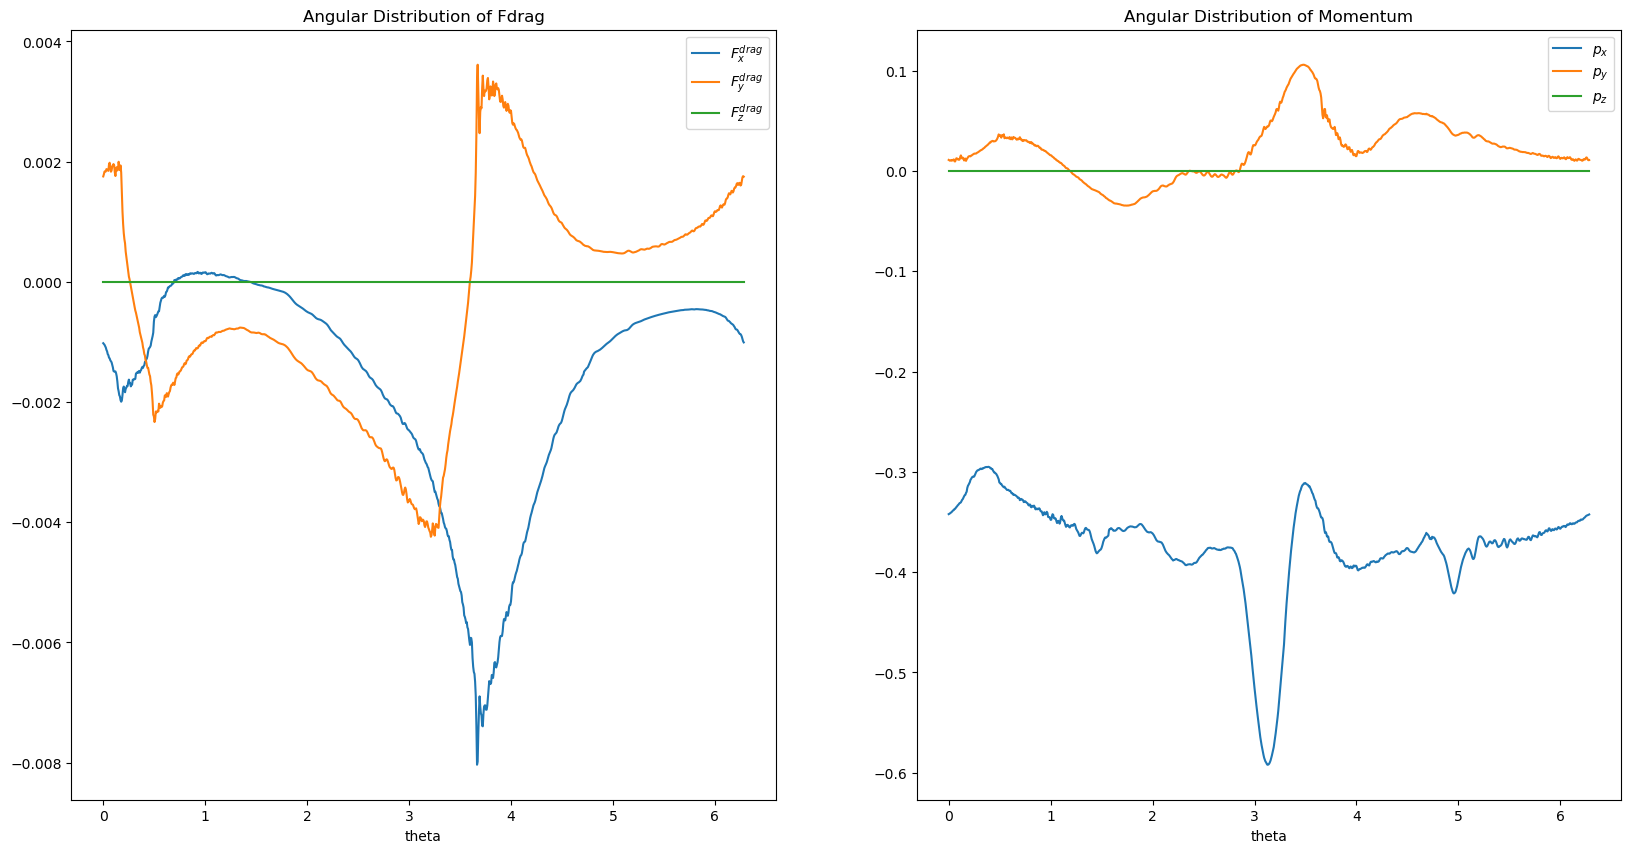

In [199]:
# plot the angular distribution of the fields
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Left panel: angular distribution of volume
axes[0].plot(theta_bins, vol_x_radial, label='$F^{drag}_x$')
axes[0].plot(theta_bins, vol_y_radial, label='$F^{drag}_y$')
axes[0].plot(theta_bins, vol_z_radial, label='$F^{drag}_z$')
axes[0].legend()
axes[0].set_xlabel('theta')
# axes[0].set_ylabel('Volume')
axes[0].set_title('Angular Distribution of Fdrag')

# Right panel: angular distribution of momentum
axes[1].plot(theta_bins, mom_x_radial, label='$p_x$')
axes[1].plot(theta_bins, mom_y_radial, label='$p_y$')
axes[1].plot(theta_bins, mom_z_radial, label='$p_z$')
axes[1].legend()
axes[1].set_xlabel('theta')
# axes[1].set_ylabel('Momentum')
axes[1].set_title('Angular Distribution of Momentum')